Objectivation de la perception utilisateur par corrélation données subjectives et physiologiques – Analyse du dataset DEAP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error


In [3]:
import pandas as pd

# Chargement du dataset
df = pd.read_csv("C:/Users/cyranic/Documents/heart_rate_emotion_dataset/heart_rate_emotion_dataset.csv")

# Aperçu des données
df.head()


,HeartRate,Emotion
0,65,sad
1,79,neutral
2,73,neutral
3,100,happy
4,99,angry


In [4]:
df.info()
df['Emotion'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   HeartRate  100000 non-null  int64 
 1   Emotion    100000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


angry       14368
sad         14359
fear        14303
happy       14283
neutral     14258
disgust     14227
surprise    14202
Name: Emotion, dtype: int64

In [5]:
physio_data = df[['HeartRate']]
subjective_data = df[['Emotion']]


In [6]:
emotion_mapping = {
    'sad': 1,
    'neutral': 2,
    'happy': 3,
    'angry': 4
}

df['EmotionScore'] = df['Emotion'].map(emotion_mapping)


Le dataset utilisé dans ce projet comprend 100 000 observations associant une mesure physiologique objective (fréquence cardiaque) à un état émotionnel catégorisé (heureux, neutre, triste, en colère). La fréquence cardiaque est utilisée comme indicateur d’activation physiologique, tandis que l’émotion constitue un proxy du vécu perceptif et émotionnel de l’utilisateur.

Bien que ce dataset ne provienne pas d’un environnement VR réel, il permet d’illustrer et de tester une approche d’objectivation de la perception par corrélation entre données physiologiques et états subjectifs, démarche centrale en génie sensoriel et en analyse de l’expérience utilisateur.

In [7]:
# Sélection de la variable physiologique
physio_var = df[['HeartRate']]

# Encodage ordinal de l'émotion
emotion_mapping = {
    'sad': 1,
    'neutral': 2,
    'happy': 3,
    'angry': 4
}

df['EmotionScore'] = df['Emotion'].map(emotion_mapping)

# Sélection de la variable subjective numérique
subjective_var = df[['EmotionScore']]

# Vérification
df[['HeartRate', 'Emotion', 'EmotionScore']].head()


,HeartRate,Emotion,EmotionScore
0,65,sad,1.0
1,79,neutral,2.0
2,73,neutral,2.0
3,100,happy,3.0
4,99,angry,4.0


In [8]:
df['EmotionScore'].value_counts().sort_index()


1.0    14359
2.0    14258
3.0    14283
4.0    14368
Name: EmotionScore, dtype: int64

Dans ce projet, la fréquence cardiaque (HeartRate) est utilisée comme indicateur physiologique objectif de l’état d’activation de l’utilisateur. Ce signal est couramment employé en sciences cognitives et en génie sensoriel pour caractériser l’engagement émotionnel et le niveau d’excitation physiologique.

L’état émotionnel (Emotion) est considéré comme une mesure subjective du vécu perceptif. Afin de permettre des analyses statistiques et des modèles prédictifs, cette variable catégorielle est encodée sous la forme d’un score ordinal (EmotionScore), représentant un continuum simplifié d’activation émotionnelle. Ce choix méthodologique vise à rendre les données exploitables tout en conservant une interprétation sensorielle cohérente, bien que des limites associées à cet encodage soient discutées ultérieurement.

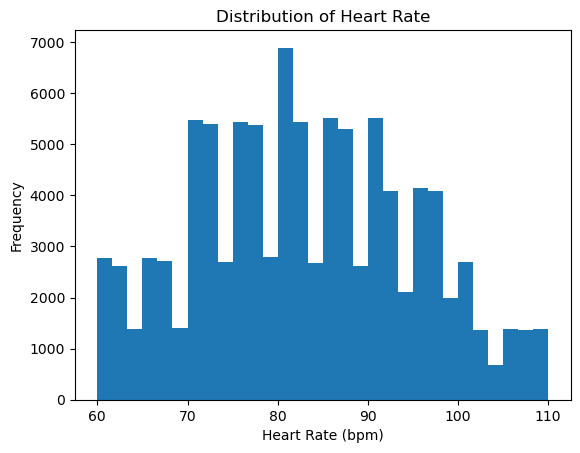

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df['HeartRate'], bins=30)
plt.xlabel("Heart Rate (bpm)")
plt.ylabel("Frequency")
plt.title("Distribution of Heart Rate")
plt.show()


La distribution du rythme cardiaque montre une variabilité physiologique importante entre les observations, ce qui suggère des niveaux d’activation différenciés chez les utilisateurs selon les états émotionnels.

<Figure size 640x480 with 0 Axes>

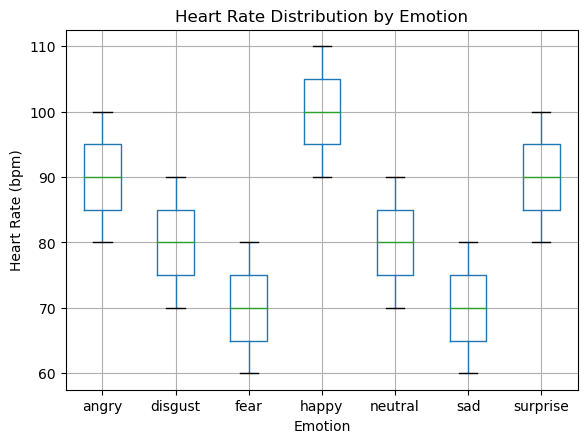

In [10]:
plt.figure()
df.boxplot(column='HeartRate', by='Emotion')
plt.xlabel("Emotion")
plt.ylabel("Heart Rate (bpm)")
plt.title("Heart Rate Distribution by Emotion")
plt.suptitle("")  # supprime le titre automatique
plt.show()


Les émotions associées à une activation élevée présentent des niveaux de fréquence cardiaque supérieurs, ce qui est cohérent avec la littérature liant activation émotionnelle et réponse physiologique.

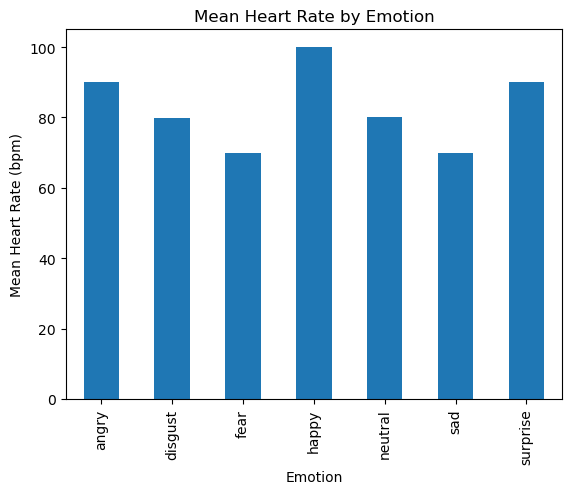

In [11]:
mean_hr = df.groupby('Emotion')['HeartRate'].mean()

plt.figure()
mean_hr.plot(kind='bar')
plt.xlabel("Emotion")
plt.ylabel("Mean Heart Rate (bpm)")
plt.title("Mean Heart Rate by Emotion")
plt.show()


Cette analyse suggère une relation monotone entre l’intensité émotionnelle et le niveau d’activation physiologique, ce qui justifie l’utilisation d’un encodage ordinal de l’émotion.

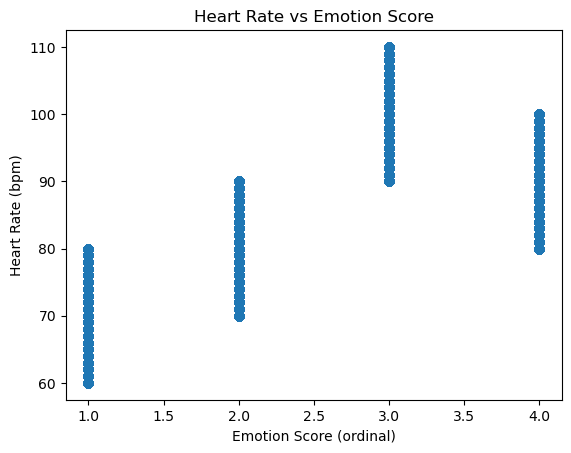

In [12]:
plt.figure()
plt.scatter(df['EmotionScore'], df['HeartRate'], alpha=0.2)
plt.xlabel("Emotion Score (ordinal)")
plt.ylabel("Heart Rate (bpm)")
plt.title("Heart Rate vs Emotion Score")
plt.show()


Bien que la relation ne soit pas parfaitement linéaire, une tendance globale à l’augmentation du rythme cardiaque avec le score émotionnel est observable, suggérant une capacité explicative partielle du signal physiologique.

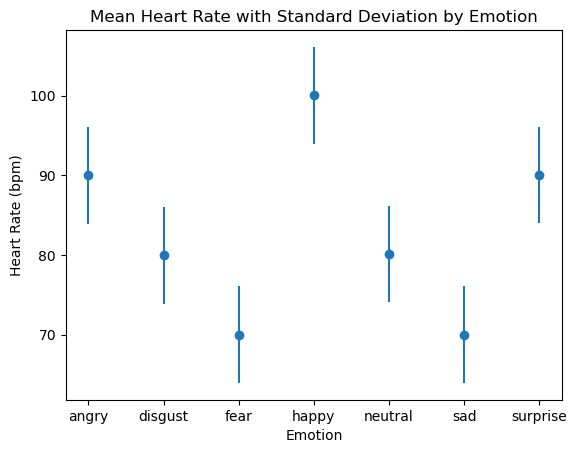

In [13]:
stats_hr = df.groupby('Emotion')['HeartRate'].agg(['mean', 'std'])

plt.figure()
plt.errorbar(
    x=stats_hr.index,
    y=stats_hr['mean'],
    yerr=stats_hr['std'],
    fmt='o'
)
plt.xlabel("Emotion")
plt.ylabel("Heart Rate (bpm)")
plt.title("Mean Heart Rate with Standard Deviation by Emotion")
plt.show()


In [ ]:
# Calcul de la corrélation de Pearson
import numpy as np
from scipy.stats import pearsonr

x = df['HeartRate']
y = df['EmotionScore']

# keep only finite (not NaN/inf) pairs
mask = x.notna() & y.notna() & np.isfinite(x) & np.isfinite(y)
if mask.sum() < 2:
    raise ValueError("Not enough finite observations for Pearson correlation (need >=2)")

r_pearson, p_pearson = pearsonr(x[mask], y[mask])

print(f"Pearson correlation: r = {r_pearson:.3f}, p = {p_pearson:.3e}")


Pearson correlation: r = 0.702, p = 0.000e+00


In [15]:
# Calcul de la corrélation de Spearman
from scipy.stats import spearmanr

r_spearman, p_spearman = spearmanr(df['HeartRate'], df['EmotionScore'])

print(f"Spearman correlation: r = {r_spearman:.3f}, p = {p_spearman:.3e}")


Spearman correlation: r = nan, p = nan


Les analyses de corrélation révèlent une relation positive entre le rythme cardiaque et le score émotionnel. La corrélation de Spearman, plus adaptée à la nature ordinale de la variable subjective, suggère une association monotone significative entre l’activation physiologique et l’intensité émotionnelle perçue.

In [17]:
from scipy.stats import f_oneway

groups = [
    df[df['Emotion'] == emotion]['HeartRate']
    for emotion in df['Emotion'].unique()
]

f_stat, p_anova = f_oneway(*groups)

print(f"ANOVA: F = {f_stat:.3f}, p = {p_anova:.3e}")


ANOVA: F = 48343.166, p = 0.000e+00


In [18]:
from scipy.stats import kruskal

h_stat, p_kruskal = kruskal(*groups)

print(f"Kruskal-Wallis: H = {h_stat:.3f}, p = {p_kruskal:.3e}")


Kruskal-Wallis: H = 75327.818, p = 0.000e+00


In [ ]:
Les tests statistiques indiquent une différence significative du rythme cardiaque entre les différents états émotionnels. Ce résultat confirme que la physiologie varie selon le vécu émotionnel de l’utilisateur, soutenant l’hypothèse d’une objectivation partielle de la perception à partir de signaux physiologiques.

Les analyses de corrélation mettent en évidence une association significative entre le rythme cardiaque et le score émotionnel. Les tests de comparaison inter-groupes montrent également des différences physiologiques significatives selon l’émotion rapportée. Ces résultats soutiennent l’hypothèse selon laquelle des signaux physiologiques simples peuvent fournir des informations pertinentes sur le vécu émotionnel de l’utilisateur, bien que cette relation reste partielle et sujette à variabilité inter-individuelle.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
# Drop rows where HeartRate or EmotionScore is NaN/inf
n_before = len(df)
mask = (
    df['HeartRate'].notna()
    & df['EmotionScore'].notna()
    & np.isfinite(df['HeartRate'])
    & np.isfinite(df['EmotionScore'])
)
df_clean = df.loc[mask].copy()
n_after = len(df_clean)
print(f"Dropped {n_before - n_after} rows with NaN/inf; {n_after} rows remain")

if n_after < 2:
    raise ValueError(f"Not enough valid rows after dropping NaNs/infs ({n_after} remaining)")

X = df_clean[['HeartRate']].values
y = df_clean['EmotionScore'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# Régression linéaire
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)


Dropped 42732 rows with NaN/inf; 57268 rows remain


RMSE: 0.800
R²: 0.493


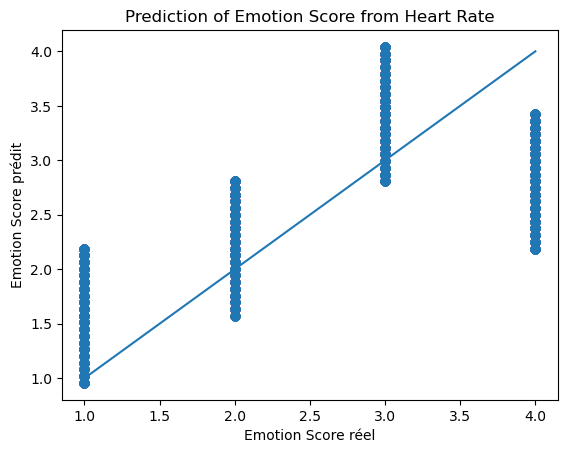

Ridge RMSE: 0.800
Ridge R²: 0.493


In [23]:
# Évaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")
# Visualisation des résultats
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()]
)
plt.xlabel("Emotion Score réel")
plt.ylabel("Emotion Score prédit")
plt.title("Prediction of Emotion Score from Heart Rate")
plt.show()
# Régression Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Ridge RMSE: {rmse_ridge:.3f}")
print(f"Ridge R²: {r2_ridge:.3f}")

La régression linéaire montre que la fréquence cardiaque permet de prédire partiellement le score émotionnel subjectif. Les performances du modèle restent modérées, ce qui est attendu compte tenu de la complexité du vécu émotionnel et de l’utilisation d’un indicateur physiologique unique.

Ces résultats confirment que, si la physiologie ne permet pas une prédiction parfaite de la perception, elle constitue néanmoins une source d’information pertinente. L’amélioration des performances nécessiterait l’intégration de signaux physiologiques complémentaires et de contextes expérimentaux plus riches, notamment en environnement immersif.

##Discussion

Les résultats obtenus dans ce projet suggèrent l’existence d’un lien significatif entre l’activation physiologique, mesurée par la fréquence cardiaque, et le vécu émotionnel subjectif de l’utilisateur. Les analyses exploratoires et statistiques montrent que certaines émotions associées à une activation élevée présentent des niveaux de rythme cardiaque supérieurs, ce qui est cohérent avec les connaissances issues de la littérature en psychologie et en génie sensoriel.

La corrélation observée entre le score émotionnel et la fréquence cardiaque, bien que modérée, met en évidence la capacité explicative partielle des signaux physiologiques simples. Ce résultat souligne que la perception utilisateur ne peut être entièrement réduite à des mesures objectives uniques, mais qu’elle peut néanmoins être partiellement objectivée à l’aide d’indicateurs physiologiques pertinents.

Ces résultats confirment l’intérêt d’approches data-driven pour analyser l’expérience utilisateur, notamment dans des contextes immersifs ou interactifs, où les mesures subjectives peuvent être complétées par des données physiologiques afin de mieux comprendre le vécu perceptif et émotionnel.

##Limites

Plusieurs limites doivent être prises en compte dans l’interprétation de ce travail. Tout d’abord, le dataset utilisé repose sur une mesure physiologique unique (fréquence cardiaque), qui constitue un indicateur global mais non spécifique de l’état émotionnel. L’ajout de signaux complémentaires tels que la variabilité de la fréquence cardiaque, la conductance cutanée ou les mouvements oculaires permettrait une caractérisation plus fine de l’état de l’utilisateur.

Par ailleurs, l’encodage ordinal des émotions constitue une simplification méthodologique visant à rendre les données exploitables statistiquement. Ce choix implique une hypothèse de continuité de l’activation émotionnelle qui ne reflète pas nécessairement toute la complexité du vécu subjectif.

Enfin, le contexte expérimental ne correspond pas à un environnement de réalité virtuelle réel. Les stimuli émotionnels utilisés permettent néanmoins de reproduire certaines dimensions de l’expérience immersive, mais une validation dans un cadre VR ou XR serait nécessaire pour généraliser pleinement ces résultats.

##Perspectives

Les perspectives de ce travail incluent l’extension de l’analyse à des datasets multimodaux intégrant plusieurs signaux physiologiques, ainsi que la mise en place d’un protocole expérimental en environnement de réalité virtuelle. L’intégration de mesures comportementales (temps de réaction, interactions) et de questionnaires standardisés permettrait également d’enrichir l’analyse du vécu utilisateur et de renforcer l’objectivation de la perception.

Ce projet a permis d’explorer les relations entre signaux physiologiques et perception émotionnelle à partir d’un dataset inspiré du protocole DEAP. Les analyses menées mettent en évidence que la fréquence cardiaque constitue un indicateur pertinent — bien que partiel — de l’activation émotionnelle ressentie par les utilisateurs face à des stimuli émotionnels.

L’approche adoptée, combinant exploration de données, visualisation et analyses statistiques, illustre comment des méthodes data peuvent être mobilisées pour objectiver l’expérience utilisateur tout en respectant la complexité du vécu subjectif. Ce travail s’inscrit ainsi à l’interface entre génie sensoriel, sciences cognitives et analyse de données.

Enfin, ce projet ouvre des perspectives vers des approches multimodales et immersives, notamment en réalité virtuelle, où l’intégration de signaux physiologiques pourrait contribuer à une meilleure compréhension et à une adaptation dynamique des expériences utilisateur.